## Caracterizacion de textura mediante LBP

Integrantes:
Adrián Cuesta

### Seccion para importar los datos desde google Drive

In [1]:

# Cargar google drive en google Colab
from google.colab import drive

# Montar carpeta de google Drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Importamos Librerias necesarias para procesar la imagen 

In [0]:
import numpy as np
from skimage import io, feature, filters           # Procesamiento de imagen
import matplotlib.pyplot as plt                    # Visualizaciones
import warnings
warnings.filterwarnings("ignore")

### Importamos las imagenes y realizamos una comprobacion de que se importaron correctamente al visualizarlas 

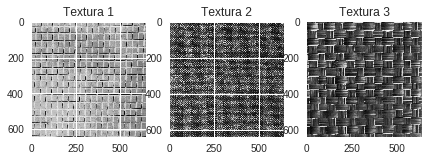

In [60]:
# Importamos la imagen desde google drive
# Colocamos una condición que nos indique si ha existido algún problema al importarlo

try:
  img1= io.imread('drive/My Drive/LBP/texture1.gif')
  img2= io.imread('drive/My Drive/LBP/texture2.gif')
  img3= io.imread('drive/My Drive/LBP/texture3.gif')

  plt.figure(figsize=[7,7])
  plt.subplot(131)
  plt.imshow(img1,cmap='gray')
  plt.title('Textura 1')
  plt.subplot(132)
  plt.imshow(img2,cmap='gray')
  plt.title('Textura 2')
  plt.subplot(133)
  plt.imshow(img3,cmap='gray')
  plt.title('Textura 3')


  plt.grid('false')

except:
  print('Error! no se pudo cargar la imagen')
  

### Importamos las librerias necesarias para procesar las imagenes

In [0]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage.color import label2rgb
from scipy.stats import entropy

 En primera instancia obtenemos el histograma resultante de obtener el operador LBP uniforme, para ello se colocaron como condiciones iniciales al LBP un radio de 3 y un numero de 24 puntos. 

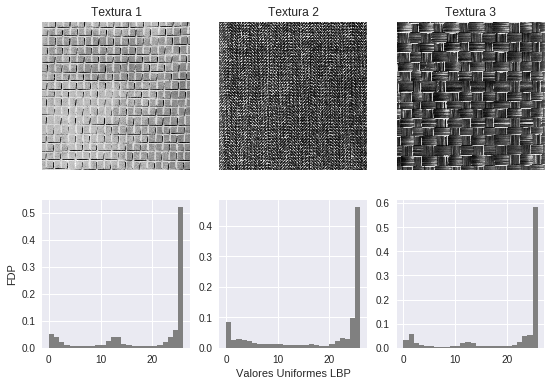

In [47]:

# Configuración para el LBP
radio = 3             # Fijamos el radio de 3
n_puntos = 24         # Fijamos el numero de puntos igual a 24
METHOD = 'uniform'    # Colocamos la opción para que sea LBP uniforme

# A continuación se define una variable (ref) que contiene el 
# resultado del LBP de las 3 imagenes iniciales con las 
#configuraciones pre establecidas. Esta variable contendra los
# LBP de las imagenes y lo utilizaremos para realizar una 
# comprobación de que las imagenes a pesar de haber sido rotadas
# siguen teniendo los mimso atributos de LBP pues se ha utilizado
# un LBP uniforme que es invariante a rotación.

refs = {
    'Text_1': local_binary_pattern(img1, n_puntos, radio, METHOD),
    'Text_2': local_binary_pattern(img2, n_puntos, radio, METHOD),
    'Text_3': local_binary_pattern(img3, n_puntos, radio, METHOD)
}


# Realizamos las grafícas de las imagenes con sus respectivos
# histogramas obtenidos a partir del LBP de cada imagen.


# plot histograms of LBP of textures
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3,
                                                       figsize=(9, 6))
plt.gray()



plt.gray()

ax1.imshow(img1)
ax1.axis('off')
ax1.set_title('Textura 1')
hist(ax4, refs['Text_1'])
ax4.set_ylabel('FDP')


ax2.imshow(img2)
ax2.axis('off')
ax2.set_title('Textura 2')
hist(ax5, refs['Text_2'])
ax5.set_xlabel('Valores Uniformes LBP')

ax3.imshow(img3)
ax3.axis('off')
ax3.set_title('Textura 3')
hist(ax6, refs['Text_3'])

plt.show()

Una vez obtenidos los resultados de LBP para cada imagen, lo siguiente es comprobar la propiedad que según la teoría tiene el LBP, su invariancia a rotación. Por lo que, a continuación se definen funciones que nos ayudaran a llevar a cabo las operaciones de rotación de las imagenes y la comparación de LBP de la imagen rotada con respecto al LBP de la imagen original. La función "match" a partir de dos LBPm las compara he indica con cual se tiene mayor similitud, esta función esta hecha de tal forma que calculara la semejanza entre todas las imagenes originales y nos entregara la que es más similiar a nuestra imagen en analisis, este proceso se repite para las 3 imagenes de textura.

Cabe destacar que aunque existen varias operaciones que se podrían realizar para medir la semejanza entre dos LBP como  nos hemos decantado por el uso de la homogeneidad, la correlación, la energía, entre otras. En este caso se utilizara la divergencia de Kullback-Leibler (también conocida como entropía relativa) para estimar la similitud entre las dos LBP y será seleccionado como match el que presente menor valor.  

In [0]:
def hist(ax, lbp):    # Funcion para obtener histograma
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), normed=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')

# Función para obtener el score de la divergencia de 
# Kullback-Leibler entre dos LBP

def kullback_leibler_divergence(p, q):   
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))

#Función que compara dos LBP he indica cual tiene mayor similitud
  
def match(refs, img):
    best_score = 10
    best_name = None
    lbp = local_binary_pattern(img, n_puntos, radio, METHOD )
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    for name, ref in refs.items():
        ref_hist, _ = np.histogram(ref, density=True, bins=n_bins,
                                   range=(0, n_bins))
        score = kullback_leibler_divergence(hist, ref_hist)
        if score < best_score:
            best_score = score
            best_name = name
    return best_name


Finalmente una vez definidas nuestras funciones, el ultimo paso es comparar las imagenes de textura originales con respecto a las imagenes de textura rotadas. En este caso se realizara una rotación de 180° en todas las imagenes y luego se realizara esta comparación.

In [53]:

# Clasificar las imagenes rotadas

print('Calsificación de las imagenes rotadas según similitud:')
print('Original: Textura 1, rotada: 180deg, resultado_match: ',
      match(refs, rotate(img1, angle=180, resize=False)))
print('Original: Textura 2, rotada: 180deg, resultado_match: ',
      match(refs, rotate(img2, angle=180, resize=False)))
print('Original: Textura 3, rotada: 180deg, resultado_match: ',
      match(refs, rotate(img3, angle=180, resize=False)))


Calsificación de las imagenes rotadas según similitud:
Original: Textura 1, rotada: 180deg, resultado_match:  Text_1
Original: Textura 2, rotada: 180deg, resultado_match:  Text_2
Original: Textura 3, rotada: 180deg, resultado_match:  Text_3


### Conclusiones 

Al realizar este ejercicio se pudo comprobar las prestaciones que nos brinda el uso de los LBP uniformes en la detección de texturas, pues al utilizar información de sus vecinos se obtiene una caracterización de la imagen que nos permite identificar las caracteristicas de una vecinidad, en este caso esas caracteristicas representan a la textura de la imagen. La aplicación la técnica de LBP ademas de la información que nos brinda por si sola, como se pudo constatar nos permite a raiz de ella obtener información adicional de la imagen y así realizar una identificación de similitud entre dos imagenes. 